In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

from scipy.sparse import issparse

In [3]:
sc.settings.set_figure_params(dpi=200, figsize=(4, 4), frameon=False)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata_full = sc.read('PT141.h5ad')

In [5]:
# do we need this?
#adata_full = adata_full[adata_full.obs.pass_QC].copy()

In [6]:
adata_full.obs.batch.value_counts()

0    10648
1     9401
Name: batch, dtype: int64

In [7]:
adata_full.obs['sample'].value_counts()

PT141_1_Negative            2767
PT141_2_RAW-SZ_untreated    2609
PT141_2_RAW-SZ_LO28_2h      2477
PT141_2_RAW-SZ_LO28_6h      2393
PT141_1_RAW-SZ_LO28_6h      2269
PT141_1_RAW-SZ_LO28_2h      2243
PT141_1_RAW-SZ_untreated    2181
PT141_2_Doublet             1714
PT141_1_Doublet             1188
PT141_2_Negative             208
Name: sample, dtype: int64

In [9]:
adata_full.layers['counts'] = adata_full.X

In [8]:
sc.pp.normalize_total(adata_full)
sc.pp.log1p(adata_full)
sc.pp.neighbors(adata_full)
sc.tl.umap(adata_full)

         Falling back to preprocessing with `sc.pp.pca` and default params.


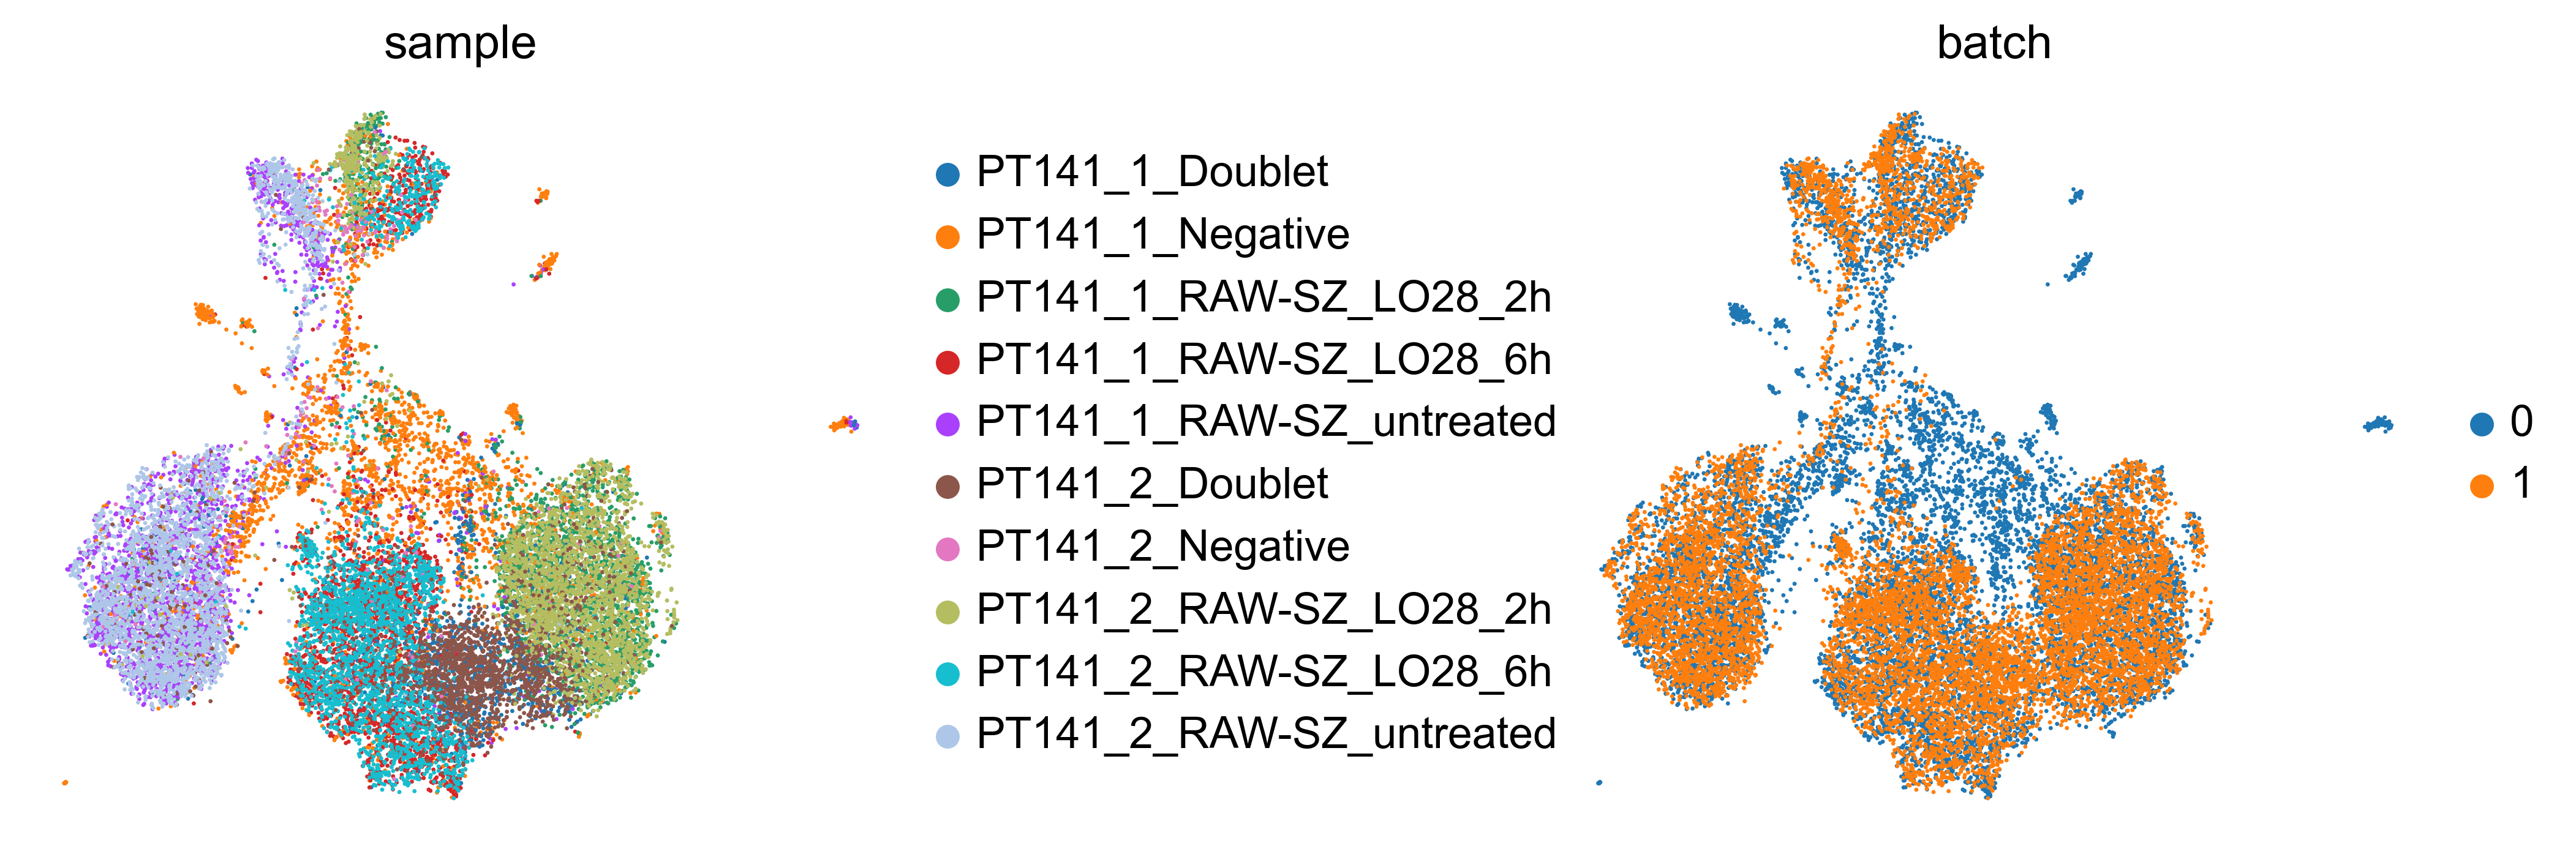

In [9]:
sc.pl.umap(adata_full, color=['sample', 'batch'], wspace=0.6)

In [10]:
adata_full.X = adata_full.layers['counts']
del adata_full.layers['counts']

In [11]:
ref = adata_full
query = None

In [9]:
del adata_full

In [21]:
sca.add_annotations(ref, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12, clean=False)
sca.add_annotations(ref, 'targets.csv', clean=False, genes_use_upper=False, varm_key='I2', uns_key='terms2')
ref.uns['terms'] += ref.uns['terms2']
ref.varm['I'] = np.concatenate((ref.varm['I'], ref.varm['I2']), axis=1)
del ref.uns['terms2']
del ref.varm['I2']

In [26]:
ref._inplace_subset_var(ref.varm['I'].sum(1)>0)

In [27]:
sc.pp.highly_variable_genes(
    ref,
    n_top_genes=6000,
    batch_key="sample",
    flavor="seurat_v3",
    subset=True)

In [28]:
select_terms = ref.varm['I'].sum(0)>12

In [29]:
ref.uns['terms'] = np.array(ref.uns['terms'])[select_terms].tolist()

In [30]:
ref.varm['I'] = ref.varm['I'][:, select_terms]

In [31]:
ref._inplace_subset_var(ref.varm['I'].sum(1)>0)

In [32]:
if issparse(ref.X):
    ref.X = ref.X.toarray()

In [36]:
ref.varm['I'].sum(0)

array([  20,   17,   18,   21,   42,   14,   24,   84,   39,  122,   44,
         16,   23,   13,   30,   36,   15,   61,   17,   36,   19,   23,
         19,  220,   36,   23,   13,   13,   37,   40,   44,   20,   21,
         13,   13,   43,   15,   24,   13,   33,   17,   17,   24,   50,
         23,   16,   29,   16,   21,   44,   53,   46,   75,   49,   13,
         17,   20,   16,   19,   19,   39,   15,   40,   33,   19,   48,
         23,   14,   14,   20,   53,   32,   22,   59,   40,   27,   47,
         36,   19,   14,   25,   69,   26,   33,   13,   15,  162,   46,
         66,   43,  175,   15,   31,   32,   14,   31,   30,   35,   52,
         63,   16,  137,   19,   19,   15,   15,   19,   16,   13,   53,
         52,   18,   20,   38,  125,   44,   15,   33,   31,   14,   50,
         73,   20,   76,   26,   20,   18,   41,   31,   22,   18,   15,
         48,   24,   33,   86,   15,  126,   52,   13,   26,   15,   27,
         22,   31,   14,   28,   13,   16,   33,   

### Create TRVAE model and train it on reference dataset

In [39]:
intr_cvae = sca.models.TRVAE(
    adata=ref,
    condition_key='sample',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=ref.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False,
    use_l_encoder=True
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 6000 256 10
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 319
Encoder Architecture:
	Input Layer in, out and cond: 6000 128 10
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  319 6000 10


In [18]:
ALPHA = 0.7

In [19]:
OMEGA = None

In [ ]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

In [21]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [ ]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

In [23]:
MEAN = False

In [24]:
ref.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [25]:
sc.pp.neighbors(ref, use_rep='X_cvae')

In [26]:
sc.tl.umap(ref)

In [ ]:
sc.pl.umap(ref, color='sample', frameon=False)

In [28]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [31]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [ ]:
query = query[:, ref.var_names].copy()

if issparse(query.X):
    query.X = query.X.toarray()

In [ ]:
q_intr_cvae = sca.models.TRVAE.load_query_data(query, intr_cvae)

In [ ]:
q_intr_cvae.train(n_epochs=200, alpha_epoch_anneal=30, weight_decay=0., alpha_kl=0.001, seed=2020, use_early_stopping=True)

In [67]:
#q_intr_cvae.save('q_intr_cvae_nolog_le_alpha_kl_0_5_0_001_sd_2020')

In [35]:
query.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [36]:
sc.pp.neighbors(query, use_rep='X_cvae')

In [37]:
sc.tl.umap(query)

In [ ]:
sc.pl.umap(query, color='sample', frameon=False, wspace=0.6)

In [ ]:
ref_query = sc.AnnData.concatenate(ref, query, batch_key='batch_join')

In [51]:
ref_query.obsm['X_cvae'] = q_intr_cvae.get_latent(ref_query.X, ref_query.obs['sample'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [52]:
sc.pp.neighbors(ref_query, use_rep='X_cvae')
sc.tl.umap(ref_query)

In [ ]:
sc.pl.umap(ref_query, color='sample', frameon=False)

In [65]:
ref_query.uns['terms'] = ref.uns['terms']

In [66]:
#ref_query.write('ko_integrated.h5ad')